<a href="https://colab.research.google.com/github/kyulee-jeon/Tutorial/blob/main/Week12_(1)ResNet_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Loading**

In [ ]:
#Connection to GoogleDrive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from glob import glob
import numpy as np
import pickle

In [ ]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/2022MedicalMachineLearning/data/COVID-19_Radiography_Dataset"
"""
#Define the file paths
all_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]
#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]
all_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]
# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths
"""

"\n#Define the file paths\nall_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]\n#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]\nall_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]\n# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths\n"

In [ ]:
#load the list
with open(os.path.join(data_path, "list_x_wk10"), "rb") as f:
  list_x = pickle.load(f)
with open(os.path.join(data_path, "list_y_wk10"), "rb") as f:
  list_y = pickle.load(f)

In [ ]:
#Gray scale to RGB
import cv2
list_x = list(map(lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB), list_x))

In [ ]:
#convert to ndarray of the data
data_x = np.array(list_x)
data_y = np.array(list_y)

In [ ]:
#save the array
"""
with open(os.path.join(data_path, "data_x_wk11"), "wb") as f:
  pickle.dump(data_x, f)
with open(os.path.join(data_path, "list_y_wk11"), "wb") as f:
  pickle.dump(data_y, f)
"""

'\nwith open(os.path.join(data_path, "data_x_wk11"), "wb") as f:\n  pickle.dump(data_x, f)\nwith open(os.path.join(data_path, "list_y_wk11"), "wb") as f:\n  pickle.dump(data_y, f)\n'

In [ ]:
print("The length of list_x is {}".format(len(list_x)))
print("The length of list_y is {}".format(len(list_y)))
print("The shape of first element of list_x is {}".format(list_x[0].shape))

del list_x, list_y

The length of list_x is 8616
The length of list_y is 8616
The shape of first element of list_x is (299, 299, 3)


In [ ]:
#one hot encoding
data_y_ = data_y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(data_y_)
data_y = ohe.transform(data_y_)

In [ ]:
data_x.shape, data_y.shape

((8616, 299, 299, 3), (8616, 2))

Data Preprocessing

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
# split into train, validation, and test sets (stratified)
#how to split validation and test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

random_seed = 11
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

from sklearn.model_selection import train_test_split
x_train, x_val_test, y_train, y_val_test = train_test_split(data_x, data_y, 
                                                            test_size = val_prop+test_prop, 
                                                            random_state = random_seed, 
                                                            stratify = data_y)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = test_prop/(val_prop+test_prop),
                                                random_state = random_seed,
                                                stratify = y_val_test)

In [ ]:
#https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
#https://discuss.pytorch.org/t/apply-transform-on-numpy-arrays/19106/9
#https://wikidocs.net/157285
#https://stackoverflow.com/questions/46586616/pytorch-trying-to-apply-the-transform-to-a-numpy-array-fails-with-an-error
#https://076923.github.io/posts/Python-pytorch-11/
#https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
class FromNPDataset(torch.utils.data.Dataset):
  def __init__(self, x, y, transform = None):
    self.x = x
    self.y = y
    self.transform = transform
    
  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]
    
    if self.transform:
      x = self.transform(x)
    else: 
      x = torch.FloatTensor(x)

    y = torch.Tensor(y)
    
    return x, y

  def __len__(self):
    return len(self.y)

In [ ]:
#from torchvision.transforms.transforms import ToPILImage

#Statistics Based on ImageNet Data for Normalisation (channel, width, height)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {'train':transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)), #Resizes all images into same dimension
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.RandomRotation(15), # Rotates the images upto Max of 15 Degrees
                                # transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    'val': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ]),
                    'test': transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Resize((150,150)),
                                # transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                                ])
                    }


In [ ]:
#Prepare torch dataset

#ds_train = FromNPDataset(x_train, y_train, transform = None)
#ds_val = FromNPDataset(x_val, y_val, transform = None)
#ds_test = FromNPDataset(x_test, y_test, transform = None)

ds_train = FromNPDataset(x_train, y_train, transform = data_transforms['train'])
ds_val = FromNPDataset(x_val, y_val, transform = data_transforms['val'])
ds_test = FromNPDataset(x_test, y_test, transform = data_transforms['test'])

In [ ]:
len(ds_train), len(ds_val), len(ds_test)

(5169, 1723, 1724)

**Defining the model**

In [ ]:
import torchvision.models as models

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
output_dim = 2
intput_channel = 3

In [ ]:
from torch import nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3,
                           stride = stride, padding =1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3,
                           stride = 1, padding =1, bias = False)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channel != out_channel:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channel, out_channel,
                    kernel_size=1, stride=stride, bias = False),
          nn.BatchNorm2d(out_channel)
      )
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x)
    out = F.relu(out)
    return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self, num_classes = 2):
    super(ResNet, self).__init__()
    self.conv0 = nn.Conv2d(in_channels = 3,
                             out_channels = 3, 
                             kernel_size = 8, 
                             stride = 1)
    
    self.in_channel = 16
    
    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3,
                           stride = 1, padding =1, bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride = 1)
    self.layer2 = self._make_layer(32, 2, stride = 2)
    self.layer3 = self._make_layer(64, 2, stride = 2)
    self.linear = nn.Linear(64, num_classes)

  def _make_layer(self, out_channel, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channel, out_channel, stride))
      self.in_channel = out_channel
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv0(x)  #299*299*3 -> #292*292*3
    x = F.max_pool2d(x, 8) # 36*36*3
    x = F.relu(x)
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
"""
W = 299 #no. of dimension
K = 5 #kernel
P = 0 #padding
S = 1 #stride
M = 2 max pooling

W = ((W - K + 2*P)/S)+1
W = W/M #after max pooling
"""

'\nW = 299 #no. of dimension\nK = 5 #kernel\nP = 0 #padding\nS = 1 #stride\nM = 2 max pooling\n\nW = ((W - K + 2*P)/S)+1\nW = W/M #after max pooling\n'

In [ ]:
model = ResNet().to(device)

In [ ]:
model

ResNet(
  (conv0): Conv2d(3, 3, kernel_size=(8, 8), stride=(1, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 292, 292]             579
            Conv2d-2           [-1, 16, 36, 36]             432
       BatchNorm2d-3           [-1, 16, 36, 36]              32
            Conv2d-4           [-1, 16, 36, 36]           2,304
       BatchNorm2d-5           [-1, 16, 36, 36]              32
            Conv2d-6           [-1, 16, 36, 36]           2,304
       BatchNorm2d-7           [-1, 16, 36, 36]              32
        BasicBlock-8           [-1, 16, 36, 36]               0
            Conv2d-9           [-1, 16, 36, 36]           2,304
      BatchNorm2d-10           [-1, 16, 36, 36]              32
           Conv2d-11           [-1, 16, 36, 36]           2,304
      BatchNorm2d-12           [-1, 16, 36, 36]              32
       BasicBlock-13           [-1, 16, 36, 36]               0
           Conv2d-14           [-1, 32,

Load the model

In [ ]:
model.load_state_dict(torch.load(os.path.join(data_path, "wk11_my_ResNet.pth")))

<All keys matched successfully>

Buildling GradCAM

In [ ]:
#https://github.com/PeterKim1/paper_code_review/blob/master/9.%20Visual%20Explanations%20from%20Deep%20Networks%20via%20Gradient-based%20Localization(Grad-CAM)/Grad-CAM_pretrained-Cat%2BDog.ipynb

In [ ]:
from torch.autograd import Function


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask = (input_img > 0).type_as(input_img)
        
        # torch.addcmul(input, tensor1, tensor2) => output = input + tensor1 x tensor 2
        # input image와 동일한 사이즈의 torch.zeros를 만든 뒤, input image와 positive_mask를 곱해서 output 생성
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        
        # backward에서 사용될 forward의 input이나 output을 저장
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        
        # forward에서 저장된 saved tensor를 불러오기
        input_img, output = self.saved_tensors
        grad_input = None

        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_1 = (input_img > 0).type_as(grad_output)
        
        # 모델의 결과가 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        
        # 먼저 모델의 결과와 positive_mask_1과 곱해주고,
        # 다음으로는 positive_mask_2와 곱해줘서 
        # 모델의 결과가 양수이면서 input image가 양수인 부분만 남도록 만들어줌
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        # 모델이 예측한 결과값을 기준으로 backward 진행
        one_hot.backward(retain_graph=True)

        # input image의 gradient를 저장
        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))
        return output

In [ ]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

In [ ]:
idx_list = np.arange(0, 10)
cam_list = []

for x in idx_list:
    finalconv_name = 'layer3'

    # activations
    feature_blobs = []

    # gradients
    backward_feature = []

    # output으로 나오는 feature를 feature_blobs에 append하도록
    def hook_feature(module, input, output):
        feature_blobs.append(output.cpu().data)

    # Grad-CAM
    def backward_hook(module, input, output):
        backward_feature.append(output[0])
        
    model._modules.get(finalconv_name).register_forward_hook(hook_feature)
    model._modules.get(finalconv_name).register_backward_hook(backward_hook)
    
    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [2, 64]        
    
    
    normed_torch_img = ds_test[x][0] #(3, 299, 299)
    normed_torch_img = torch.unsqueeze(normed_torch_img, 0) #(1, 3, 299, 299)
    normed_torch_img = normed_torch_img.to(device)

    img = np.transpose(normed_torch_img.cpu().numpy().squeeze(), (1, 2, 0)) # (224, 224, 3)

    img = np.interp(img, (img.min(), img.max()), (0, 1))


    # Prediction
    logit = model(normed_torch_img)
    h_x = F.softmax(logit, dim=1).data.squeeze() # softmax 적용
    probs, idx = h_x.sort(0, True)
    #print("True label : %d, Predicted label : %d, Probability : %.2f" % (target.item(), idx[0].item(), probs[0].item()))
        

    # ============================= #
    # ==== Grad-CAM main lines ==== #
    # ============================= #

    img_size = (299,299) #(224, 224)
    score = logit[:, idx[0]].squeeze() # 예측값 y^c
    score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

    activations = feature_blobs[0].to(device) # (1, 512, 7, 7), forward activations
    gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
    b, k, u, v = gradients.size()

    alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
    weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

    grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
    grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
    grad_cam_map = F.interpolate(grad_cam_map, size=img_size, mode='bilinear', align_corners=False) # (1, 1, 224, 224)
    map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
    grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

    # grad_cam_map.squeeze() : (224, 224)
    grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy

    # Grad-CAM heatmap save
    # cv2.imwrite(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg"), grad_heatmap)

    grad_heatmap = np.float32(grad_heatmap) / 255

    grad_result = grad_heatmap + img
    grad_result = grad_result / np.max(grad_result)
    grad_result = np.uint8(255 * grad_result)
    cam_list.append(grad_result)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


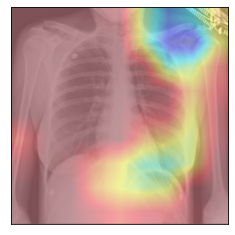

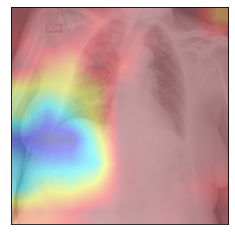

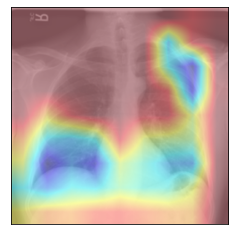

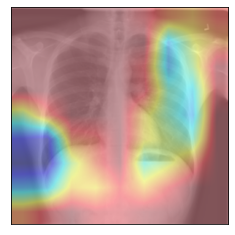

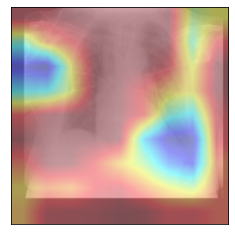

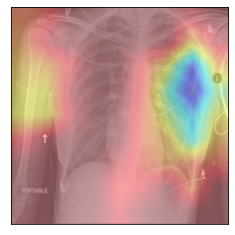

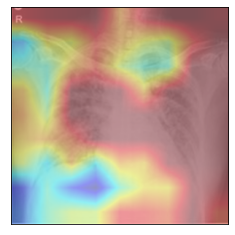

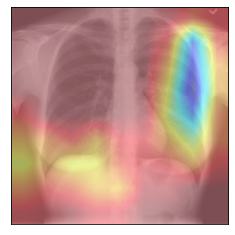

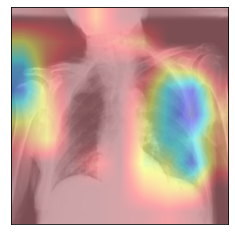

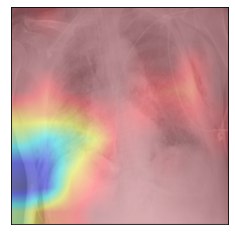

In [ ]:
import matplotlib.pyplot as plt
for x in cam_list:
    plt.imshow(x, alpha=0.7)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()